## Scalable Gaussian Process Regression Examples. 
Throughout we take the objective to be the MSE plus the RKHS norm regularizer, so that we may not only apply the Representer Theorem but also obtain a closed form for the solution by checking first order optimality conditions. 
### Methods
1. The first is simply Kernel Ridge Regression: $$ f(x) = k(x, X) (K(X, X) + \lambda I)^{-1} y$$ which has time complexity $\mathcal{O}(n^3)$ coming from having to invert an $n \times n$ matrix. 
2. The second one is the Nystrom method where $S$ represents a set of inducing points. $$ f(x) = k(x, X) \cdot \Big( K(S, X) K(X, S) + \lambda K(S, S) \Big)^{\dagger} K(S, X) y$$ which has time complexity $\mathcal{O}(n^2m)$. Note that the burden is not the matrix inversion, but rather the matrix multiplications. 
3. The third is choosing $m << n$ points and using those while disregarding the rest of training examples: 
$$ f(x) = k(x, X_m) \cdot \Big( K(X_m, X_m) + \lambda I_m \Big)^{-1} y $$

_Remarks_: Note that the eigenvalues of the covariance matrices decay quite fast, which leads to very ill-conditioned linear systems. The RKHS norm regularization aids with this by shifting all eigenvalues by $\lambda$. However, when using the Nystrom approximation we, in some sense, lose this benefit because we end up inverting a smaller matrix __without__ the shift. If the set of inducing points is chosen appropriately, we may be lucky and obtain a well-conditioned submatrix, but this is often not the case. Hence the pseudoinverse notation. Recall that the Nystrom is far more general than the subset selection procedure we outline here, so a possible future direction is to invesitgate "test" matrices $\Omega \in \mathbb{R}^{n \times m}$ that yield better conditioned matrices $\tilde{K} = \Omega^* K(X, X) \Omega$.  

In [75]:
from jax import vmap, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import time

key = random.key(563)

Define RBF kernel, true underlying function, and use vmap to vectorize the kernel function such that if $X \in \mathbb{R}^{n \times d}$ and $Y \in \mathbb{R}^{m \times d}$, then $k(X, Y) \in \mathbb{R}^{n \times m}$, and $k(X, Y)_{ij} = k(X[i, :], Y[j, :])$.

In [146]:
def kernel(gamma):
    def rbf(x, y):
        return jnp.exp(-gamma*jnp.sum((x-y)**2))
    return rbf

def f(x):
    return 3*jnp.sin(1.6*jnp.pi*x)**(3) + x

k = kernel(gamma=0.1)
vec_k = vmap(vmap(k, in_axes=(None ,0)), in_axes=(0, None))

Now define the amount of points we want to train on, and define the observations given by $y = f(x) + \epsilon$, where $\epsilon  \sim \mathcal{N}(0,K =  0.01 I)$.

In [81]:
n, n_test = 15000, 200
X, X_test = jnp.linspace(0, np.pi, n), jnp.linspace(0, jnp.pi, n_test)
y = f(X) + 0.1*random.normal(key, shape = X.shape)
true_f = f(X_test)
K = vec_k(X, X)
lam = 1e-2

First the standard Kernel Ridge Regression:

In [82]:
start = time.time()
# --------------------------------
alpha = jnp.linalg.solve(K + lam * jnp.eye(K.shape[0]), y)
f_predict = vec_k(X_test, X) @ alpha
# --------------------------------
end = time.time()

print(f"FULL KRR DONE AT {end - start} seconds")
print(f"Full KRR Error: {jnp.linalg.norm(true_f - f_predict)/n_test}")

FULL KRR DONE AT 16.92161250114441 seconds
Full KRR Error: 0.000463226722786203


Then randomly select a set of $m << n$ inducing points to do Nystrom. 

In [92]:
m = 10
idxs = random.permutation(key, n)[:m]
K_mm = K[:, idxs][idxs, :]
K_nm = K[:, idxs]

# NOW NYSTROM
#-----------------------------
start = time.time()
alpha = jnp.linalg.solve(K_nm.T @ K_nm + lam * n_test * K_mm + 1e-6*jnp.eye(m),  K_nm.T @ y)
f_nystrom_predict = vec_k(X_test, X[idxs]) @ alpha
end = time.time()

#---------------------------------
print(f"NYSTROM DONE IN {end - start} seconds")
print(f"Nystrom Error: {jnp.linalg.norm(true_f - f_nystrom_predict)/n_test}")

NYSTROM DONE IN 1.2980170249938965 seconds
Nystrom Error: 0.03629857674241066


In [93]:
# STRICT SUBSET OF DATA
# ----------------------------
start = time.time()
alpha = jnp.linalg.solve(K_mm + lam * np.eye(m), y[idxs])
f_subset_predict = vec_k(X_test, X[idxs]) @ alpha
end = time.time()

print(f"STRICT SUBSET DONE IN {end  - start} seconds")
print(f"SoD Error: {jnp.linalg.norm(true_f - f_subset_predict)/n_test}")

STRICT SUBSET DONE IN 0.016213178634643555 seconds
SoD Error: 0.056248389184474945


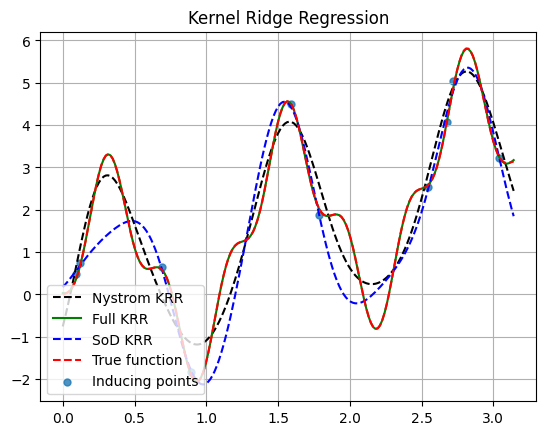

In [94]:
plt.plot(X_test, f_nystrom_predict, '--k', label='Nystrom KRR')
plt.plot(X_test, f_predict, '-g', markersize= 15, label='Full KRR')
plt.plot(X_test, f_subset_predict, '--b', label="SoD KRR")
plt.plot(X_test, true_f, '--r', markersize = 30, label="True function")

plt.grid()
plt.title("Kernel Ridge Regression")
# plt.scatter(X, y, label="Train points", alpha=0.6, s=25)
plt.scatter(X[idxs], y[idxs], label="Inducing points", alpha=0.8, s=25)
plt.legend(loc='lower left')